In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest




import ast
import numpy as np
import matplotlib.pyplot as plt
import nbimporter
import nbformat
from Data_preparation import train_test_split_for_data_autoencoder
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Dense
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from keras.models import Sequential




## Functions to work with

In [5]:
def autoencoder_train(x_train, latent_dim:int, divider:int):
    input_dim = x_train.shape[1] 
    autoencoder = Sequential()
    
    autoencoder.add(Dense(input_dim, activation='relu', input_shape = (input_dim,)))
    autoencoder.add(Dense(int(input_dim/divider), activation='relu', kernel_initializer='he_uniform'))
    autoencoder.add(Dense(latent_dim, activation='relu', kernel_initializer='he_uniform'))
    autoencoder.add(Dense(int(input_dim/divider), activation='relu', kernel_initializer='he_uniform'))
    autoencoder.add(Dense(input_dim, activation='relu', kernel_initializer='he_uniform'))
    custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    autoencoder.compile(loss='mean_squared_error', optimizer=custom_optimizer)
    autoencoder.summary()

    history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=128, validation_split=0.2)
    return autoencoder, history

In [6]:
def autoencoder_evaluate(model, x_test, y_test, difference_calculating_function, threshold_of_difference, with_cm):
    predictions = model.predict(x_test)
    real_count_vectors = x_test.to_numpy()
    difference_vector = difference_calculating_function(predictions, real_count_vectors)
    y_pred =  (difference_vector > threshold_of_difference).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    if with_cm:
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.title("Confusion Matrix")
        plt.show()
        print(cm)
    precision = (cm[1,1]) / (cm[1,1] + cm[0,1])
    recall = (cm[1,1]) / (cm[1,1] + cm[1,0])
    f_score = 2*precision*recall / (precision+recall)
    return precision, recall, f_score

In [7]:
def difference_calculating_function_cosine_dissimilarity(predictions, real_count_vectors):
    difference_vector = np.zeros(len(predictions))
    
    #Loop through each pair of corresponding vectors
    for i in range(len(predictions)):
        vector_a = predictions[i]
        vector_b = real_count_vectors[i]
            
        dot_product = np.dot(vector_a, vector_b)
        norm_a = np.linalg.norm(vector_a)
        norm_b = np.linalg.norm(vector_b)
            
        cosine_similarity = dot_product / (norm_a * norm_b)
        difference_vector[i] = 1 - cosine_similarity
        
    return difference_vector

In [8]:
def difference_calculating_function_l_norm(predictions,  real_count_vectors):
    difference_vector = np.zeros(len(predictions))
    for i in range(len(predictions)):
        vector_a = predictions[i]
        vector_b = real_count_vectors[i]

        difference_vector[i] = np.linalg.norm(vector_a-vector_b, ord = 1)
    return difference_vector

In [9]:
def plot_history(history):
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

In [10]:
def create_f_score_recall_precision_plots(model, x_test, y_test, difference_calculating_function, thresholds, title):
    f_scores_list = []
    recalls_list = []
    precisions_list = []
    for threshold in thresholds:
        precision, recall, f_score = autoencoder_evaluate(model, x_test, y_test, difference_calculating_function, threshold, False)
        f_scores_list.append(f_score)
        recalls_list.append(recall)
        precisions_list.append(precision)
    plt.plot(thresholds, f_scores_list, label = 'F-score')
    plt.plot(thresholds, precisions_list, label = 'Precision')
    plt.plot(thresholds, recalls_list, label = 'Recalls')
    plt.xlabel('Thresholds')
    plt.ylabel('Score value')
    plt.legend()
    plt.title(title)
    plt.show()


## Fully unsupervised learning

c:\Users\mathb\Python\envs\diplomamunka\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 48)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,100 (16.02 KB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2987 - val_loss: 0.3766
Epoch 2/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3105 - val_loss: 0.3781
Epoch 3/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3021 - val_loss: 0.3774
Epoch 4/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3151 - val_loss: 0.2606
Epoch 5/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1746 - val_loss: 0.2118
Epoch 6/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1666 - val_loss: 0.2103
Epoch 7/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1689 - val_loss: 0.2180
Epoch 8/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2029 - val_loss: 0.2824
Epoch 9/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0994 - val_loss: 0.1493
Epoch 10/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0770 - val_loss: 0.1224
Epoch 11/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0772 - val_loss: 0.1281
Epoch 12/100
2876/2

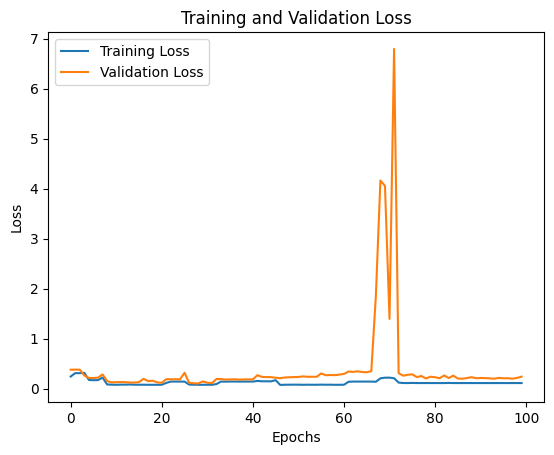

In [90]:
x_train, y_train, x_test, y_test = train_test_split_for_data_autoencoder('../Data/HDFS_v1/Processed_data/processed_labeled_data.csv', 0.2, False)
autoencoder_model, history = autoencoder_train(x_train,4,3)
plot_history(history)
autoencoder_model.save("../Models/autoencoder_model_unsupervised_non_sequential2.keras")

3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 926us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595

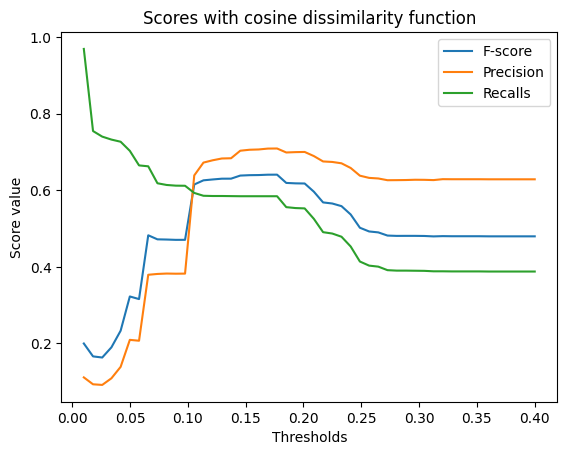

In [91]:
loaded_model = load_model("../Models/autoencoder_model_unsupervised_non_sequential2.keras")
thresholds = np.linspace(start = 0.01, stop = 0.4, num = 50, endpoint = True)
create_f_score_recall_precision_plots(loaded_model, x_test, y_test, difference_calculating_function_cosine_dissimilarity, thresholds, 'Scores with cosine dissimilarity function')

3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 

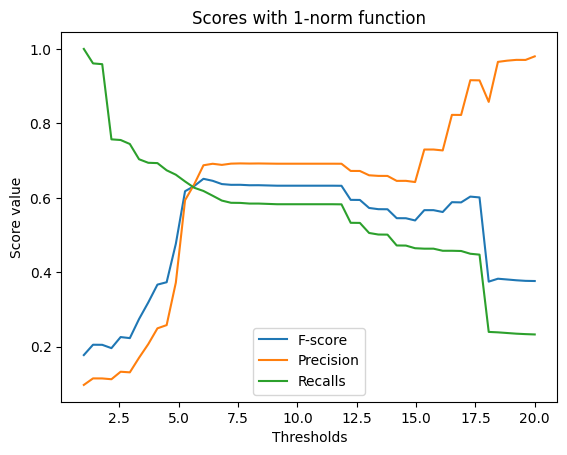

In [92]:
loaded_model = load_model("../Models/autoencoder_model_unsupervised_non_sequential2.keras")
thresholds = np.linspace(start = 1, stop = 20, num = 50, endpoint = True)
create_f_score_recall_precision_plots(loaded_model, x_test, y_test, difference_calculating_function_l_norm, thresholds, 'Scores with 1-norm function')

## Semisupervised autoencoder

In [11]:
x_train_success, y_train_success, x_test_success, y_test_success, x_train_fail, y_train_fail, x_test_fail, y_test_fail = train_test_split_for_data_autoencoder('../Data/HDFS_v1/Processed_data/processed_labeled_data.csv', 0.2, True)
x_test = pd.concat([x_test_success, x_test_fail], ignore_index=True)
y_test = pd.concat([y_test_success, y_test_fail], ignore_index=True)
autoencoder_model, history = autoencoder_train(x_train_success,4,3)
autoencoder_model.save("../Models/autoencoder_model_semisupervised_non_sequential2.keras")


c:\Users\mathb\Python\envs\diplomamunka\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 48)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,100 (16.02 KB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.7282 - val_loss: 0.6474
Epoch 2/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6863 - val_loss: 0.6475
Epoch 3/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6602 - val_loss: 0.6474
Epoch 4/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6594 - val_loss: 0.6474
Epoch 5/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6581 - val_loss: 0.6474
Epoch 6/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6450 - val_loss: 0.6474
Epoch 7/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6481 - val_loss: 0.6475
Epoch 8/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.6455 - val_loss: 0.6478
Epoch 9/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6685 - val_loss: 0.6475
Epoch 10/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6547 - val_loss: 0.6474
Epoch 11/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6629 - val_loss: 0.6475
Epoch 12/100
2792/2

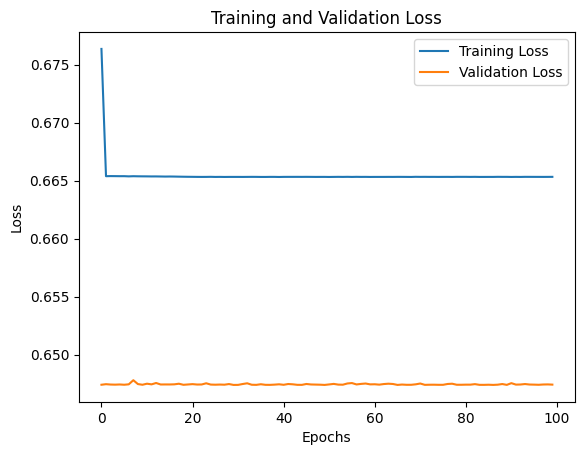

3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 978us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 988us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 940us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/

C:\Users\mathb\AppData\Local\Temp\ipykernel_17800\4208641211.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = (cm[1,1]) / (cm[1,1] + cm[0,1])


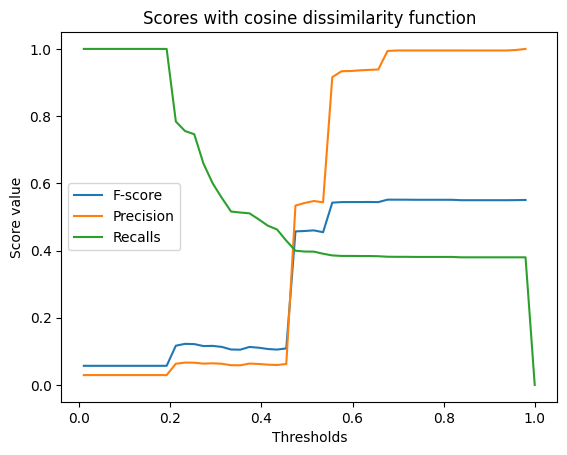

3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━

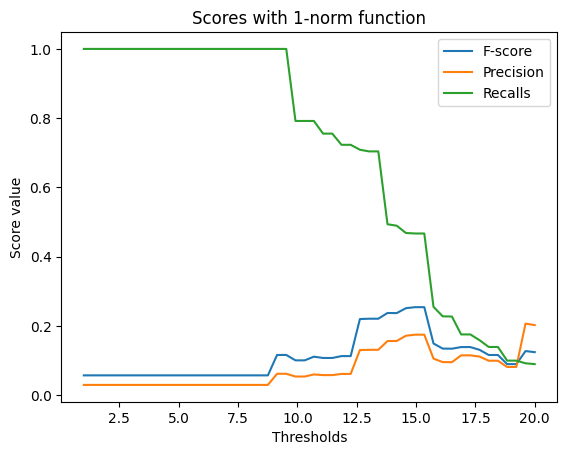

In [14]:
plot_history(history)
thresholds = np.linspace(start = 0.01, stop = 1, num = 50, endpoint = True)
create_f_score_recall_precision_plots(autoencoder_model, x_test, y_test, difference_calculating_function_cosine_dissimilarity, thresholds, 'Scores with cosine dissimilarity function')
thresholds = np.linspace(start = 1, stop = 20, num = 50, endpoint = True)
create_f_score_recall_precision_plots(autoencoder_model, x_test, y_test, difference_calculating_function_l_norm, thresholds, 'Scores with 1-norm function')